In [1]:
import h5py
import numpy as np
import puma
import matplotlib.pyplot as plt
from puma import Histogram, HistogramPlot, Roc, RocPlot
from puma.metrics import calc_rej
from puma.utils import get_good_colours, get_good_linestyles, logger
from sklearn import metrics
from numpy.lib.recfunctions import structured_to_unstructured as s2u

In [2]:
import tqdm.notebook as tqdm

In [3]:
#test_path = '/storage/agrp/zivka/umami_Tau/UPP/umami-preprocessing/upp/output/pp_output_test.h5'
test_path = '/storage/agrp/dreyet/GNtau/samples/v04/output/pp_output_test.h5'
#model_path = 'logs/GN2TauA_20230820-T185727/ckpts/epoch=009-val_loss=0.04711__test_pp_output_test.h5'
#model_path = '/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_20230918-T144357/ckpts/epoch=017-val_loss=0.05848__test_pp_output_test.h5'
#model_path = '/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_20230924-T171327/ckpts/epoch=019-val_loss=0.05785__test_pp_output_test.h5'
model_path = '/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_trkClsWgt_noRNN_20230927-T145302/ckpts/epoch=031-val_loss=0.05314__test_pp_output_test.h5'

#'/storage/agrp/dmitrykl/tauTag/upp/output/pp_output_test.h5'

In [4]:
test_file = h5py.File(test_path, 'r')
model_file = h5py.File(model_path, 'r')
    

In [5]:
jet_flav = test_file['jets']['HadronConeExclTruthLabelID']
is_tau = jet_flav == 5
#is_tau = np.ones_like(is_tau) ### HACK!

In [6]:
x = test_file['tracks']['tauTruthProng']
x = x[is_tau]

In [7]:
sig_1_prong = np.isin(x, 1)
sig_mask_1 = np.any(sig_1_prong, axis=1)
sig_3_prong = np.isin(x, 3)
sig_mask_3 = np.any(sig_3_prong, axis=1)

In [8]:
#track_vars = ['rnn_fakeScore','rnn_chargedScore','rnn_conversionScore', 'rnn_isolationScore', 'valid', 'NewTruthType']

In [9]:
# track_dict = {}
# for var in track_vars:
#   track_dict[var] = test_file['tracks'][var]

In [10]:
filtered = [test_file['tracks']['rnn_fakeScore'],test_file['tracks']['rnn_chargedScore'],test_file['tracks']['rnn_conversionScore'],test_file['tracks']['rnn_isolationScore'],test_file['tracks']['valid'],test_file['tracks']['NewTruthType']]

In [11]:
filtered = np.stack(filtered, axis=-1)

In [12]:
filtered_tau = filtered[is_tau]
track_scores = [filtered_tau[:,:,0], filtered_tau[:,:,1], filtered_tau[:,:,2], filtered_tau[:,:,3]]
track_valids = filtered_tau[:,:,4]
track_truth = filtered_tau[:,:,5]

In [13]:
track_valids = np.where(track_valids == 1, True, False)

In [14]:
valid_truth = track_truth[track_valids]
valid_truth[valid_truth == 6] = 0
valid_truth[valid_truth == 5] = 0
valid_truth[valid_truth == 4] = 0
valid_truth.shape


(36541661,)

In [15]:
rnn_scores = np.stack([track_scores[0], track_scores[1], track_scores[2], track_scores[3]], axis=-1)

In [16]:
tracks_pred = model_file['tracks'].fields(['0', '1', '2', '3', '4', '5', '6'])[:]

In [17]:
new_pred = s2u(tracks_pred)


In [18]:
new_pred[is_tau].shape

(3000000, 30, 7)

In [19]:
track_valids.shape

(3000000, 30)

In [20]:
new_pred = new_pred[is_tau][track_valids]

In [21]:
new_pred.shape

(36541661, 7)

In [22]:
new_pred[:, 0] = new_pred[:, 0] + new_pred[:, 4] + new_pred[:, 5] + new_pred[:, 6]
new_pred = new_pred[:, :4]

In [23]:
new_pred = np.argmax(new_pred, axis=-1)

In [24]:
new_pred.shape

(36541661,)

In [25]:
np.unique(new_pred)

array([0, 1, 2, 3])

In [26]:
def relabel(labels):
    labels = labels + 100 # 0 -> 100, 1 -> 101, 2 -> 102, 3 -> 103
    labels = np.where(labels == 100, 3, labels)
    labels = np.where(labels == 101, 0, labels)
    labels = np.where(labels == 102, 1, labels)
    labels = np.where(labels == 103, 2, labels)
    return labels

In [27]:
new_pred = relabel(new_pred)

In [28]:
valid_truth = relabel(valid_truth)

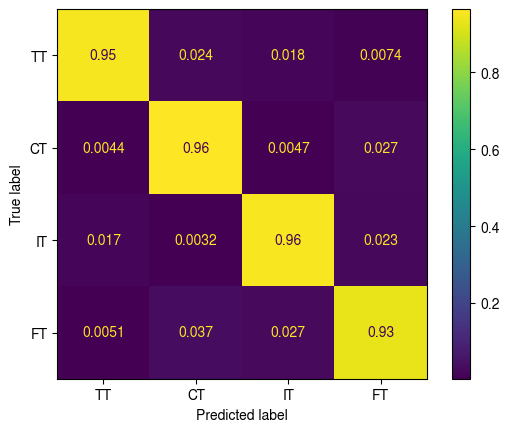

In [29]:
confusion_matrix = metrics.confusion_matrix(valid_truth, new_pred, normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['TT', 'CT', 'IT', 'FT'])

cm_display.plot()
plt.show()

In [30]:
three_prong_jet_mask = [ np.sum(track_true_labels == 1) == 3  for track_true_labels in track_truth] 

In [31]:
np.sum(l == True for l in three_prong_jet_mask)

/tmp/ipykernel_226392/3278942670.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(l == True for l in three_prong_jet_mask)


549568

In [32]:
three_prong_jet_mask = np.array(three_prong_jet_mask)

In [33]:
filtered_3_prongs = filtered_tau[three_prong_jet_mask & sig_mask_3]

In [34]:
filtered_3_prongs.shape

(535308, 30, 6)

In [35]:
track_scores3 = [filtered_3_prongs[:,:,0], filtered_3_prongs[:,:,1], filtered_3_prongs[:,:,2], filtered_3_prongs[:,:,3]]
track_valid3 = filtered_3_prongs[:,:,4]
track_truth3 = filtered_3_prongs[:,:,5]

In [36]:
track_valid3 = np.where(track_valid3 == 1, True, False)

In [37]:
track_valid3.shape

(535308, 30)

In [38]:
valid_truth3 = track_truth3[track_valid3]
valid_truth3[valid_truth3 == 6] = 0
valid_truth3[valid_truth3 == 5] = 0
valid_truth3[valid_truth3 == 4] = 0
valid_truth3.shape

(6626117,)

In [39]:
rnn_scores3 = np.stack([track_scores3[0], track_scores3[1], track_scores3[2], track_scores3[3]], axis=-1)

In [40]:
new_pred = s2u(tracks_pred)

In [41]:
new_pred3 = new_pred[is_tau][three_prong_jet_mask & sig_mask_3]

In [42]:
new_pred3 = new_pred3[track_valid3]

In [43]:
new_pred3[:, 0] = new_pred3[:, 0] + new_pred3[:, 4] + new_pred3[:, 5] + new_pred3[:, 6]
new_pred3 = new_pred3[:, :4]

In [44]:
new_pred3 = np.argmax(new_pred3, axis=-1)

In [45]:
new_pred3 = relabel(new_pred3)

In [46]:
valid_truth3 = relabel(valid_truth3)

In [47]:
new_pred3.shape

(6626117,)

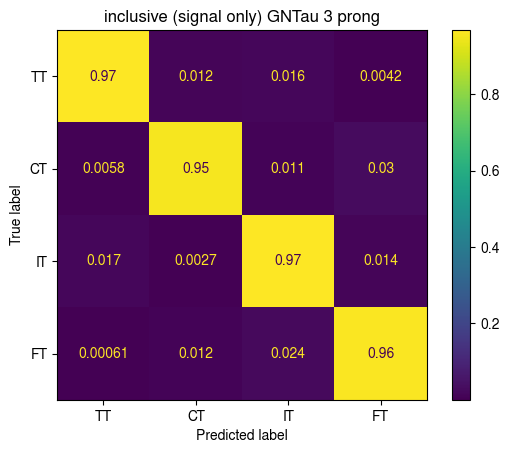

In [48]:
confusion_matrix = metrics.confusion_matrix(valid_truth3, new_pred3, normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['TT', 'CT', 'IT', 'FT'])

cm_display.plot()
plt.title('inclusive (signal only) GNTau 3 prong')
plt.show()

In [49]:
sig_mask_1.shape

(3000000,)

In [50]:
one_prong_jet_mask = [np.sum(track_true_labels == 1) == 1  for track_true_labels in track_truth]

In [51]:
np.sum(l == True for l in one_prong_jet_mask)

/tmp/ipykernel_226392/3261831915.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(l == True for l in one_prong_jet_mask)


2069771

In [52]:
one_prong_jet_mask = np.array(one_prong_jet_mask)

In [53]:
filtered_1_prongs = filtered_tau[one_prong_jet_mask & sig_mask_1]

In [54]:
track_scores1 = [filtered_1_prongs[:,:,0], filtered_1_prongs[:,:,1], filtered_1_prongs[:,:,2], filtered_1_prongs[:,:,3]]
track_valid1 = filtered_1_prongs[:,:,4]
track_truth1 = filtered_1_prongs[:,:,5]

In [55]:
track_valid1 = np.where(track_valid1 == 1, True, False)

In [56]:
valid_truth1 = track_truth1[track_valid1]
valid_truth1[valid_truth1 == 6] = 0
valid_truth1[valid_truth1 == 5] = 0
valid_truth1[valid_truth1 == 4] = 0
valid_truth1.shape

(24340231,)

In [57]:
rnn_scores1 = np.stack([track_scores1[0], track_scores1[1], track_scores1[2], track_scores1[3]], axis=-1)


In [58]:
new_pred = s2u(tracks_pred)

In [59]:
new_pred1 = new_pred[is_tau][one_prong_jet_mask & sig_mask_1]

In [60]:
new_pred1 = new_pred1[track_valid1]

In [61]:
new_pred1[:, 0] = new_pred1[:, 0] + new_pred1[:, 4] + new_pred1[:, 5] + new_pred1[:, 6]
new_pred1 = new_pred1[:, :4]

In [62]:
new_pred1 = np.argmax(new_pred1, axis=-1)

In [63]:
new_pred1 = relabel(new_pred1)

In [64]:
valid_truth1 = relabel(valid_truth1)

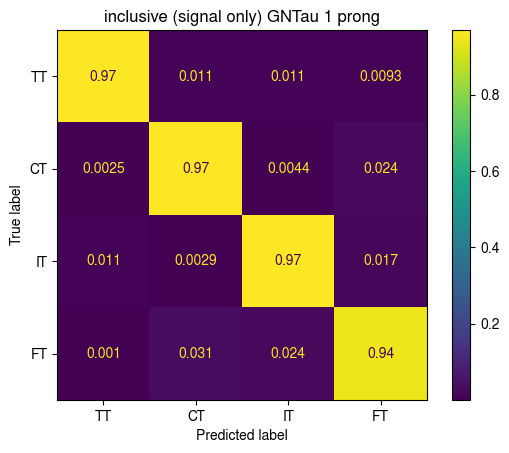

In [65]:
confusion_matrix = metrics.confusion_matrix(valid_truth1, new_pred1, normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['TT', 'CT', 'IT', 'FT'])

cm_display.plot()
plt.title('inclusive (signal only) GNTau 1 prong')
plt.show()

# Prongness distribution

In [66]:
# True
tau_true_prongness     = np.array([ np.sum(track_true_labels == 1) for track_true_labels in track_truth])
tau_true_prongness_1   = tau_true_prongness == 1
tau_true_prongness_3   = tau_true_prongness == 3

### Jet scores

In [67]:
### Working points
WP_1p = {
    'Tight': 0.60,
    'Medium': 0.75,
    'Loose': 0.85,
}

WP_3p = {
    'Tight': 0.45,
    'Medium': 0.60,
    'Loose': 0.75,
}

In [68]:
# RNN
tau_score_RNN  = test_file['jets']['TAU_RNNJetScoreSigTrans'][is_tau]

# GNN
tau_score_GNN = model_file['jets']['GN2TauA_trkClsWgt_noRNN_pb'][is_tau]

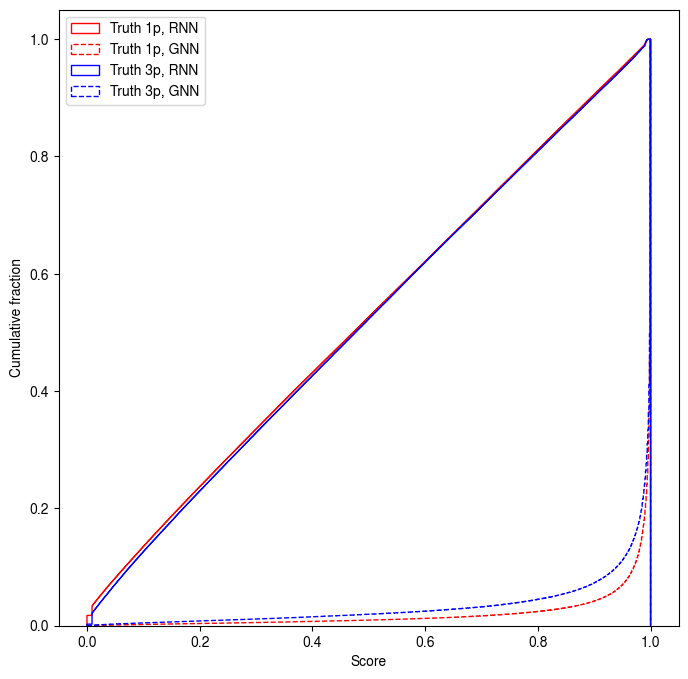

WP Tight: RNN=0.5779816069846283, GNN=0.9992642518626927
WP Medium: RNN=0.7357205186791296, GNN=0.999540157414183
WP Loose: RNN=0.841037040259144, GNN=0.9997240944485097
WP Tight: RNN=0.4246743981550613, GNN=0.9984437512899295
WP Medium: RNN=0.5794849463399372, GNN=0.9992023921385538
WP Loose: RNN=0.7379959324403768, GNN=0.9995014950865961


In [69]:
### plot cumulative distribution of GNN score
plt.figure(figsize=(8, 8))
y_1p_RNN, _, _ = plt.hist(tau_score_RNN[tau_true_prongness_1], bins=1000, range=(0, 1), histtype='step', density=True, cumulative=True, label='Truth 1p, RNN', color='red')
y_1p_GNN, _, _ = plt.hist(tau_score_GNN[tau_true_prongness_1], bins=1000, range=(0, 1), histtype='step', density=True, cumulative=True, label='Truth 1p, GNN', color='red', linestyle='dashed')
y_3p_RNN, _, _ = plt.hist(tau_score_RNN[tau_true_prongness_3], bins=1000, range=(0, 1), histtype='step', density=True, cumulative=True, label='Truth 3p, RNN', color='blue')
y_3p_GNN, _, _ = plt.hist(tau_score_GNN[tau_true_prongness_3], bins=1000, range=(0, 1), histtype='step', density=True, cumulative=True, label='Truth 3p, GNN', color='blue', linestyle='dashed')
plt.xlabel('Score')
plt.ylabel('Cumulative fraction')
plt.legend()
plt.show()

### print the intercepts with the working points
for wp in WP_1p:
    print(f'WP {wp}: RNN={np.interp(WP_1p[wp], y_1p_RNN, np.linspace(0, 1, len(y_1p_RNN)))}, GNN={np.interp(WP_1p[wp], y_1p_GNN, np.linspace(0, 1, len(y_1p_GNN)))}')
for wp in WP_3p:
    print(f'WP {wp}: RNN={np.interp(WP_3p[wp], y_3p_RNN, np.linspace(0, 1, len(y_3p_RNN)))}, GNN={np.interp(WP_3p[wp], y_3p_GNN, np.linspace(0, 1, len(y_3p_GNN)))}')

### Track scores

In [70]:
# RNN
track_scores_RNN = np.stack([test_file['tracks']['rnn_fakeScore'], test_file['tracks']['rnn_chargedScore'], test_file['tracks']['rnn_isolationScore'], test_file['tracks']['rnn_conversionScore']], axis=-1)[is_tau]
tau_pred_prongness_RNN = np.sum(np.argmax(track_scores_RNN, axis=-1)==1, axis=-1)

In [71]:
# GNN
track_scores_GNN = np.stack([model_file['tracks']['0'], model_file['tracks']['1'], model_file['tracks']['2'], model_file['tracks']['3'],model_file['tracks']['4'],model_file['tracks']['5'],model_file['tracks']['6']], axis=-1)[is_tau]

In [72]:
track_scores_GNN[:, :, 0] = track_scores_GNN[:, :, 0] + track_scores_GNN[:, :, 4] + track_scores_GNN[:, :, 5] + track_scores_GNN[:, :, 6]
track_scores_GNN = track_scores_GNN[:, :, :4]

In [73]:
track_scores_GNN.shape

(3000000, 30, 4)

In [74]:
track_pred_class_GNN = np.argmax(track_scores_GNN, axis=-1)

In [75]:
tau_pred_prongness_GNN = np.array([np.sum(p[v]==1) for p,v in tqdm.tqdm(zip(track_pred_class_GNN, track_valids), total=len(track_valids))])

  0%|          | 0/3000000 [00:00<?, ?it/s]

In [76]:
# Crazy!
np.unique(tau_pred_prongness_GNN)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29])

In [79]:
### Working point cuts on jet class discriminant (from other notebook)
disc_cut_1p_GNN = {'Tight': 0.9985942244529724, 'Medium': 0.9949994683265686, 'Loose': 0.9860391616821289}
disc_cut_3p_GNN = {'Tight': 0.9994408488273621, 'Medium': 0.998101532459259, 'Loose': 0.9922864437103271}
disc_cut_1p_RNN = {'Tight': 0.3752514302730561, 'Medium': 0.22267189621925354, 'Loose': 0.12556235641241073}
disc_cut_3p_RNN = {'Tight': 0.5426434129476547, 'Medium': 0.3887053191661835, 'Loose': 0.23480135947465897}

In [92]:
def plot_prongness(workingpoint='Medium'):

    disc_min_1p_GNN = disc_cut_1p_GNN[workingpoint] if workingpoint is not None else 0
    disc_min_1p_RNN = disc_cut_1p_RNN[workingpoint] if workingpoint is not None else 0
    disc_min_3p_GNN = disc_cut_3p_GNN[workingpoint] if workingpoint is not None else 0
    disc_min_3p_RNN = disc_cut_3p_RNN[workingpoint] if workingpoint is not None else 0

    workingpoint_max = 'Medium' if workingpoint == 'Loose' else 'Tight' if workingpoint == 'Medium' else None

    disc_max_1p_GNN = disc_cut_1p_GNN[workingpoint_max] if workingpoint_max is not None else 1.1
    disc_max_1p_RNN = disc_cut_1p_RNN[workingpoint_max] if workingpoint_max is not None else 1.1
    disc_max_3p_GNN = disc_cut_3p_GNN[workingpoint_max] if workingpoint_max is not None else 1.1
    disc_max_3p_RNN = disc_cut_3p_RNN[workingpoint_max] if workingpoint_max is not None else 1.1

    disc_mask_1p_GNN = (tau_score_GNN > disc_min_1p_GNN) & (tau_score_GNN < disc_max_1p_GNN)
    disc_mask_1p_RNN = (tau_score_RNN > disc_min_1p_RNN) & (tau_score_RNN < disc_max_1p_RNN)
    disc_mask_3p_GNN = (tau_score_GNN > disc_min_3p_GNN) & (tau_score_GNN < disc_max_3p_GNN)
    disc_mask_3p_RNN = (tau_score_RNN > disc_min_3p_RNN) & (tau_score_RNN < disc_max_3p_RNN)

    # histogram of GNN predicted prongness for 1 and 3 prong taus
    fig , ax = plt.subplots(figsize=(8,6), dpi=150)
    bins = np.linspace(-0.5, 4.5, 6)
    ax.hist(tau_pred_prongness_RNN[disc_mask_1p_RNN & tau_true_prongness_1], range=(-0.5,4.5), bins=bins, label='Truth 1p (RNN)', histtype='step', density=True, color='red')
    ax.hist(tau_pred_prongness_RNN[disc_mask_3p_RNN & tau_true_prongness_3], range=(-0.5,4.5), bins=bins, label='Truth 3p (RNN)', histtype='step', density=True, color='blue')
    ax.hist(tau_pred_prongness_GNN[disc_mask_1p_GNN & tau_true_prongness_1], range=(-0.5,4.5), bins=bins, label='Truth 1p (GNN aux)', histtype='step', density=True, color='red', linestyle='dashed')
    ax.hist(tau_pred_prongness_GNN[disc_mask_3p_GNN & tau_true_prongness_3], range=(-0.5,4.5), bins=bins, label='Truth 3p (GNN aux)', histtype='step', density=True, color='blue', linestyle='dashed')
    ax.set_ylim(0, 1.2)
    workingpoint = 'None' if workingpoint is None else workingpoint
    plt.text(0.05, 0.95, f'Tau ID WP: {workingpoint} (excl.)', transform=ax.transAxes, fontsize=14, verticalalignment='top')
    plt.legend()
    plt.xlabel('Predicted prongness')
    plt.ylabel('Normalized')
    plt.savefig(f'prongness_{workingpoint}.png')
    plt.show()

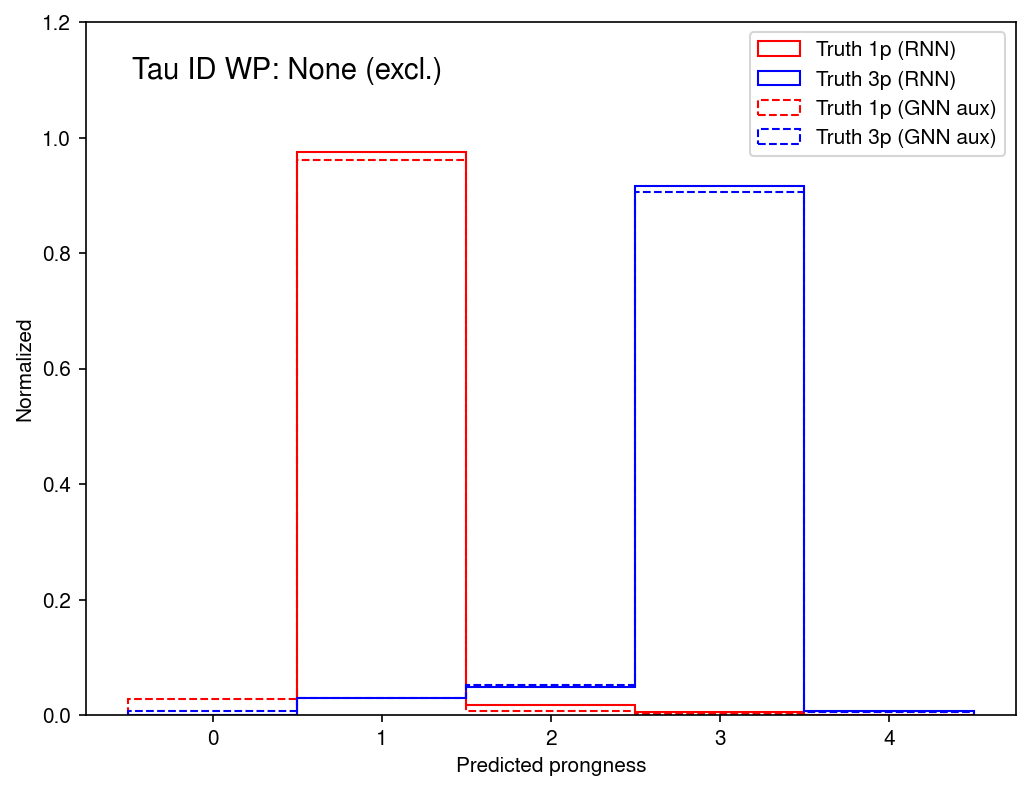

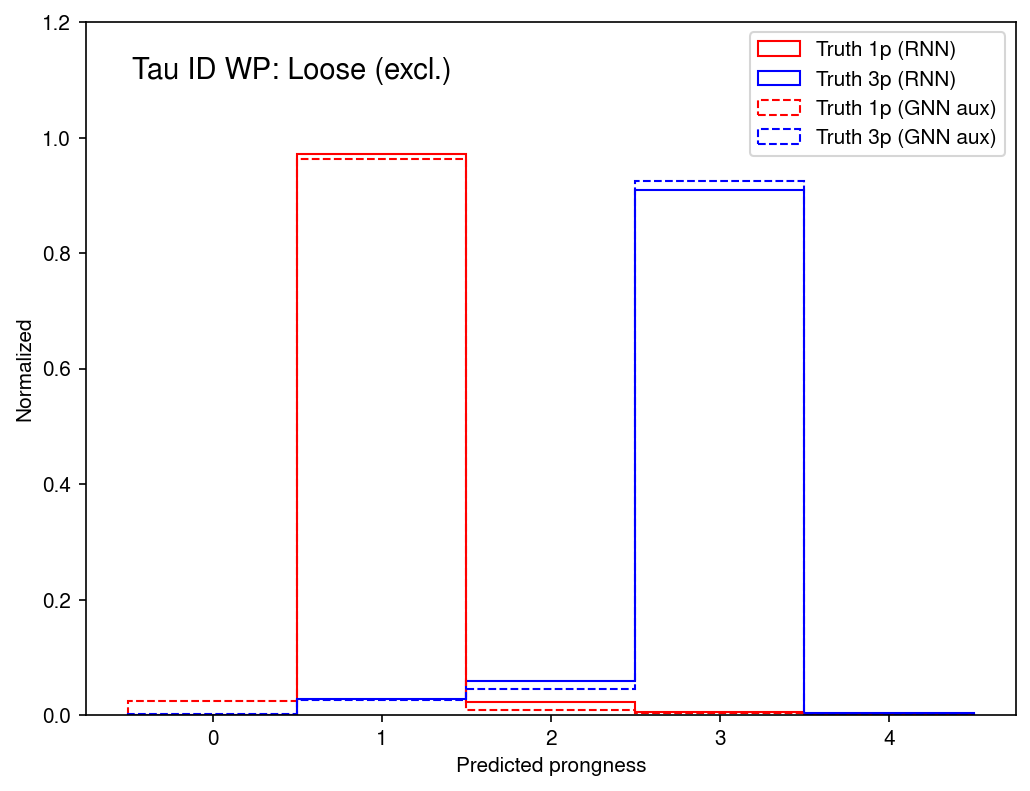

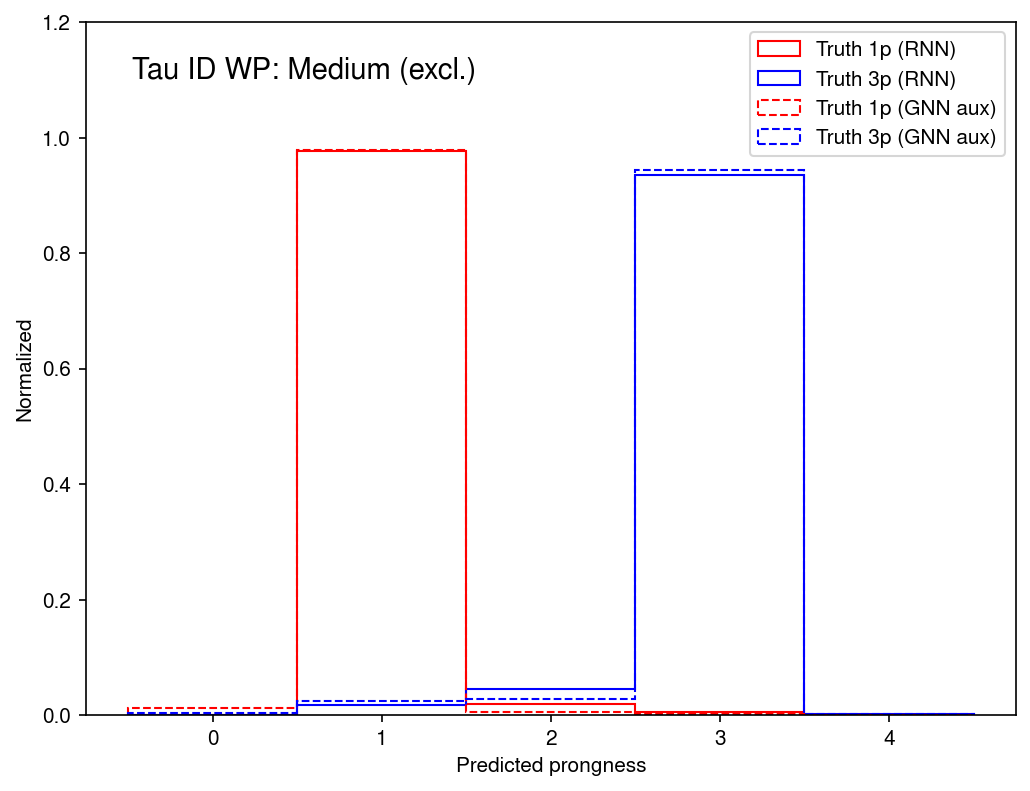

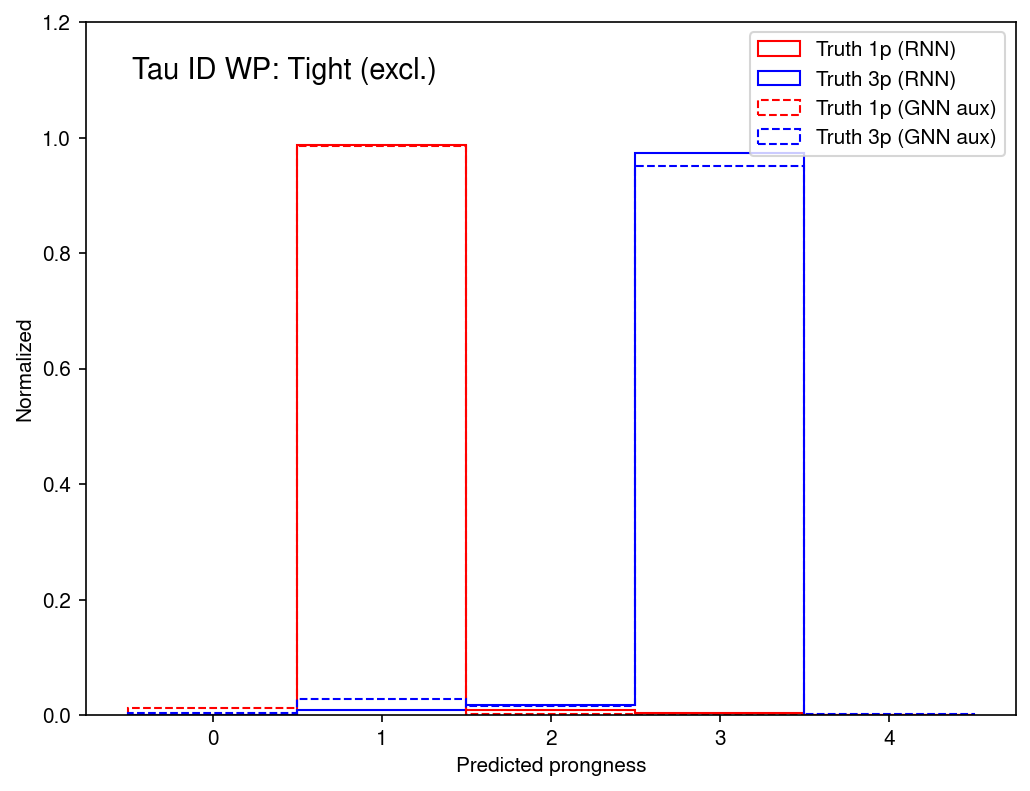

In [93]:
plot_prongness(None)
plot_prongness('Loose')
plot_prongness('Medium')
plot_prongness('Tight')

# Check track label proportions

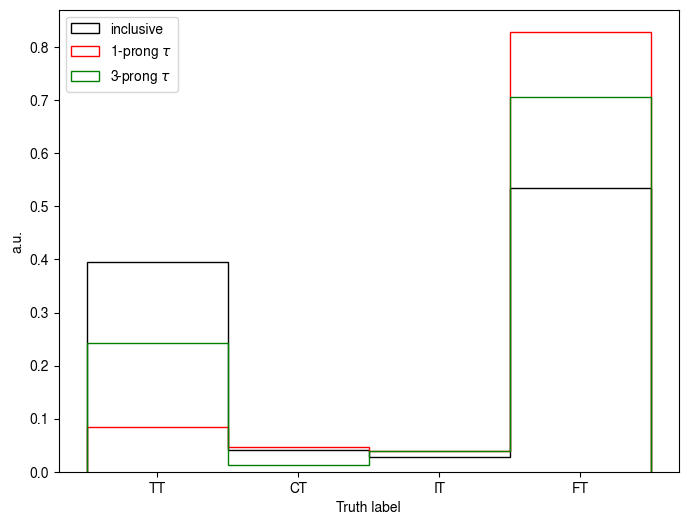

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(valid_truth,  bins=4, range=(0,4), histtype='step', color='black', density=True, label='inclusive')
ax.hist(valid_truth1, bins=4, range=(0,4), histtype='step', color='red', density=True, label='1-prong $\\tau$')
ax.hist(valid_truth3, bins=4, range=(0,4), histtype='step', color='green', density=True, label='3-prong $\\tau$')

labels = ['TT', 'CT', 'IT', 'FT']
ax.set_xticks(np.arange(len(labels)) + 0.5)
ax.set_xticklabels(labels)

ax.set_xlabel('Truth label')
ax.set_ylabel('a.u.')
ax.legend()
plt.show()

In [86]:
class_ids = [0, 1, 2, 3]
counts_incl = np.array([np.sum(valid_truth == i) for i in class_ids])
freq_incl = counts_incl / len(valid_truth)

weights_incl = (1 / freq_incl)/len(class_ids)

In [88]:
print(freq_incl)
print(weights_incl)

[0.3957824  0.04098632 0.02811673 0.53511454]
[0.63166022 6.09959554 8.89150331 0.46718969]


In [98]:
relabel_indices = [3, 0, 1, 2]
weights_incl_original = weights_incl[relabel_indices]
weights_incl_original = weights_incl_original
print(weights_incl_original)

[0.46718969 0.63166022 6.09959554 8.89150331]


(array([52457075., 42916529.,  4444338.,  3048828.,  4445859.,   118995.,
         1003033.]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <BarContainer object of 7 artists>)

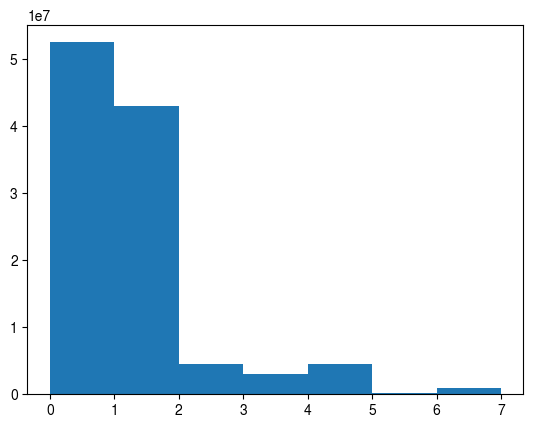

In [90]:
plt.hist(track_truth[track_valids], bins=7, range=(0,7))